In [2]:
import os
 
print("username:" , os.getlogin())
from datetime import date

today = date.today()
print("Today's date:", today)

username: rafae
Today's date: 2022-11-16


In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [5]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

c:\Users\rafae\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
import os
os.getcwd()

'e:\\Coursera or ONLINE\\MS BAnDS\\3rd Sem\\BAN 5753 Advanced Analytics\\Week 12'

In [7]:
from platform import python_version

print(python_version())

3.10.1


In [8]:
sc.version #spark version

'3.3.0'

### Read Data

In [9]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


### Sample of Data

In [10]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

### DataTypes

In [11]:


df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



### Distrubution of Target Variable

In [12]:
df.groupby("Y").count().show()

+---+-----+
|  Y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [13]:
# renaming the 4 variables to remove dot (.) from their names
df=df.withColumnRenamed("emp.var.rate","EmpVarRate")\
    .withColumnRenamed("cons.price.idx","ConsPriceIndx")\
    .withColumnRenamed("nr.employed","NrEmployed" ) \
    .withColumnRenamed("cons.conf.idx","ConsConfIndx" ) 

df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- EmpVarRate: double (nullable = true)
 |-- ConsPriceIndx: double (nullable = true)
 |-- ConsConfIndx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- NrEmployed: double (nullable = true)
 |-- y: string (nullable = true)



### Statistics 

In [14]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
EmpVarRate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
ConsPriceIndx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
ConsConfIndx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


In [15]:
#identifying null values
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'EmpVarRate': 0,
 'ConsPriceIndx': 0,
 'ConsConfIndx': 0,
 'euribor3m': 0,
 'NrEmployed': 0,
 'y': 0}

##### So, no null values

### Export to Examine

In [16]:
df.toPandas().to_csv('data.csv')

In [17]:
# finding the cardinality of categorical columns
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
for c in categorical_features:
    count1=df.select(c).distinct().count()
    print('Cardinality of ' + c +' is ', count1)

Cardinality of job is  12
Cardinality of marital is  4
Cardinality of education is  8
Cardinality of default is  3
Cardinality of housing is  3
Cardinality of loan is  3
Cardinality of contact is  2
Cardinality of month is  10
Cardinality of day_of_week is  5
Cardinality of poutcome is  3
Cardinality of y is  2


In [18]:
# finding the distinct values in categorical columns
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
for c in categorical_features:
    count2=df.select(c).distinct().show()
    print(count2)

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

None
+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+

None
+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+

None
+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+

None
+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+

None
+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+

None
+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+

None
+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  mar|
|  oct|
|  j

In [19]:
df.groupby("job").count().show()
df.groupby("marital").count().show()
df.groupby("education").count().show()
df.groupby("default").count().show()
df.groupby("housing").count().show()
df.groupby("loan").count().show()
df.groupby("contact").count().show()
df.groupby("month").count().show()
df.groupby("day_of_week").count().show()
df.groupby("poutcome").count().show()
#should unkown be nan?

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 2924|
|      retired| 1720|
|      unknown|  330|
|self-employed| 1421|
|      student|  875|
|  blue-collar| 9254|
| entrepreneur| 1456|
|       admin.|10422|
|   technician| 6743|
|     services| 3969|
|    housemaid| 1060|
|   unemployed| 1014|
+-------------+-----+

+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 4612|
| married|24928|
|  single|11568|
+--------+-----+

+-------------------+-----+
|          education|count|
+-------------------+-----+
|        high.school| 9515|
|            unknown| 1731|
|           basic.6y| 2292|
|professional.course| 5243|
|  university.degree|12168|
|         illiterate|   18|
|           basic.4y| 4176|
|           basic.9y| 6045|
+-------------------+-----+

+-------+-----+
|default|count|
+-------+-----+
|unknown| 8597|
|     no|32588|
|    yes|    3|
+-------+-----+

+-------+-----+
|housing|count|
+-------+-----+
|unknown|  9

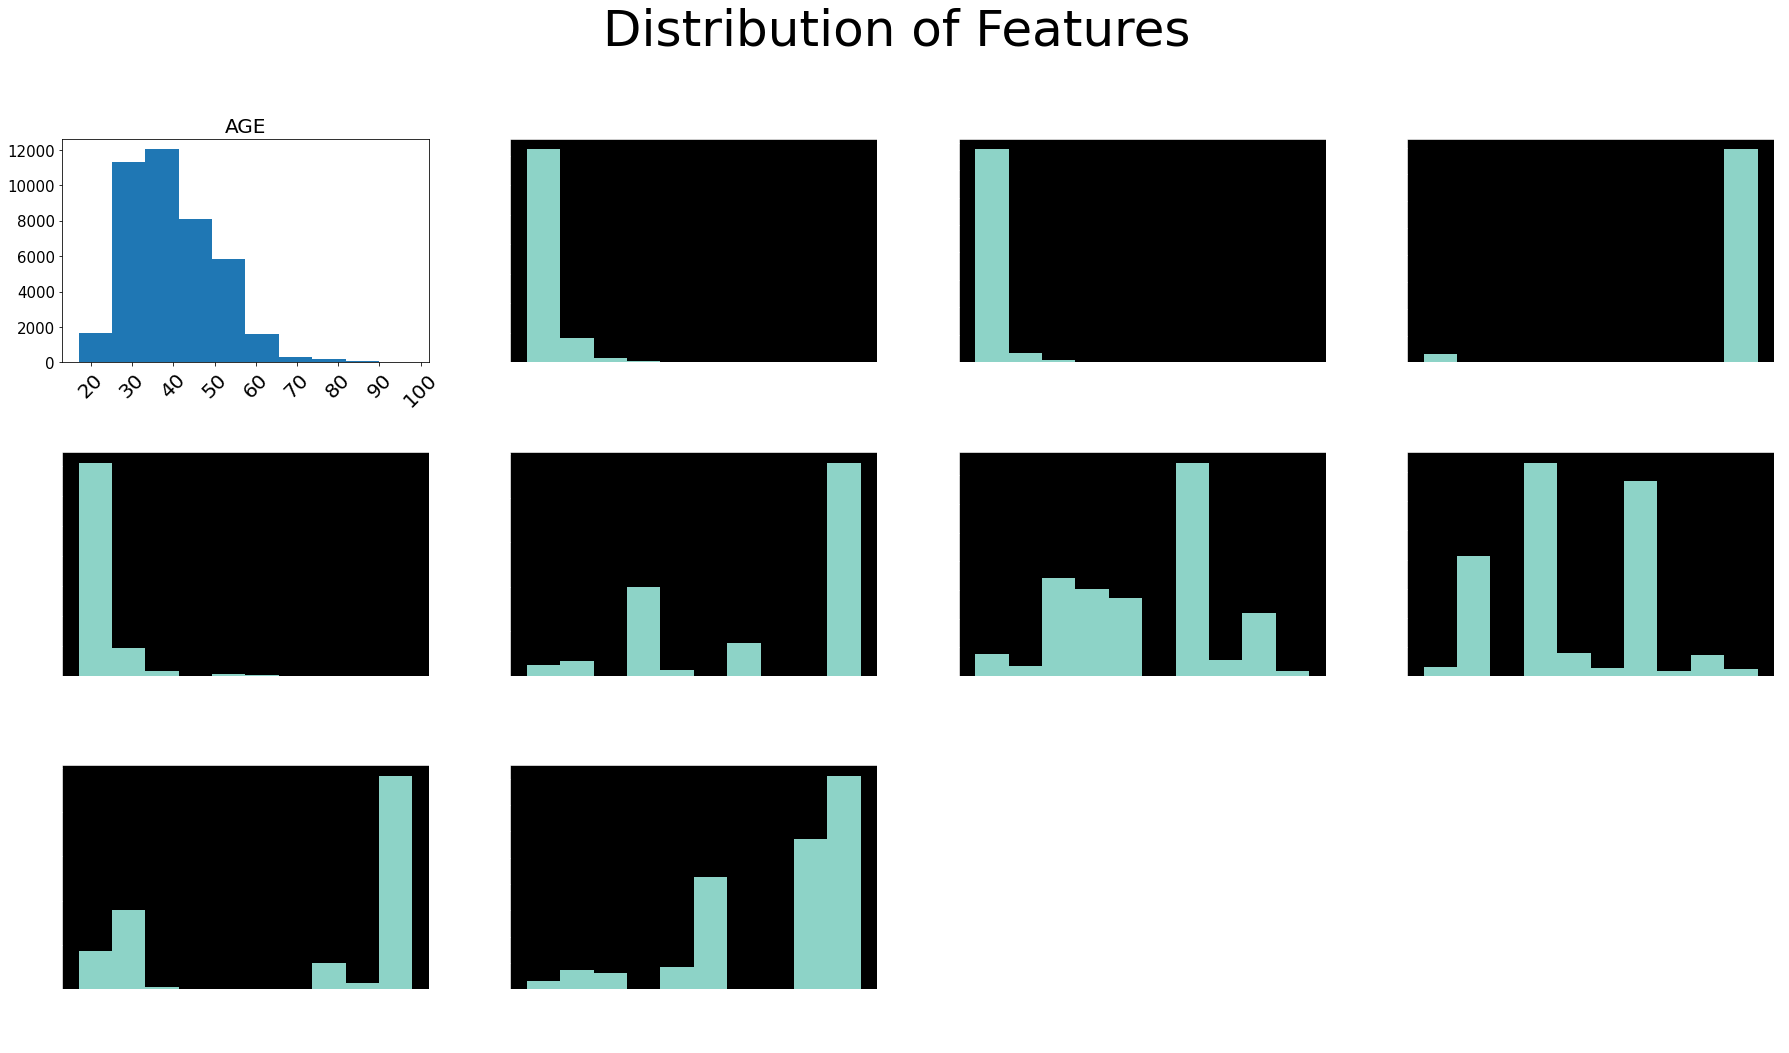

In [20]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,12)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [21]:
#from pyspark.pandas.DataFrame.plot import bar   

#df.toPandas().plot.bar(x='y', y='age') 
#plt.show()


#Bivariate Analysis

<AxesSubplot:xlabel='age', ylabel='y'>

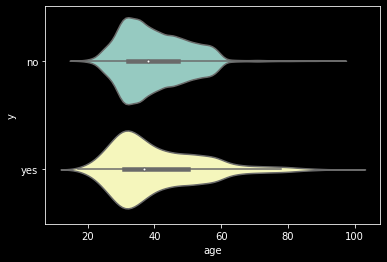

In [22]:
import seaborn
seaborn.violinplot(data=df.toPandas(), x='age', y='y')

<AxesSubplot:xlabel='duration', ylabel='y'>

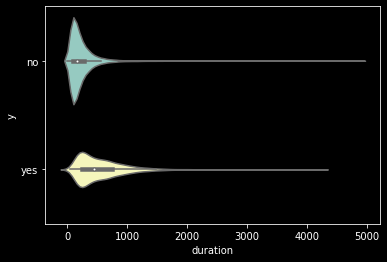

In [23]:
seaborn.violinplot(data=df.toPandas(), x='duration', y='y')

<AxesSubplot:xlabel='campaign', ylabel='y'>

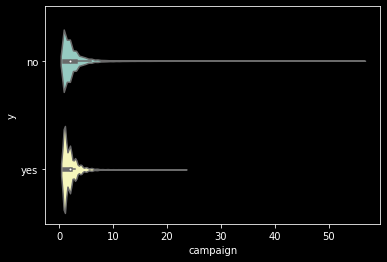

In [24]:
seaborn.violinplot(data=df.toPandas(), x='campaign', y='y')

<AxesSubplot:xlabel='pdays', ylabel='y'>

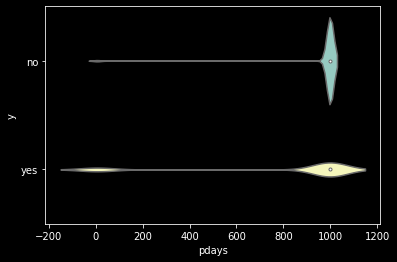

In [25]:
seaborn.violinplot(data=df.toPandas(), x='pdays', y='y')

<AxesSubplot:xlabel='previous', ylabel='y'>

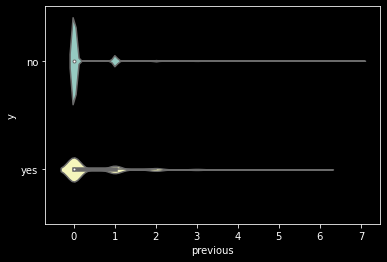

In [26]:
seaborn.violinplot(data=df.toPandas(), x='previous', y='y')

<AxesSubplot:xlabel='EmpVarRate', ylabel='y'>

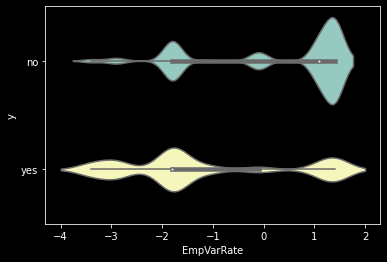

In [27]:
seaborn.violinplot(data=df.toPandas(), x='EmpVarRate', y='y')

<AxesSubplot:xlabel='ConsPriceIndx', ylabel='y'>

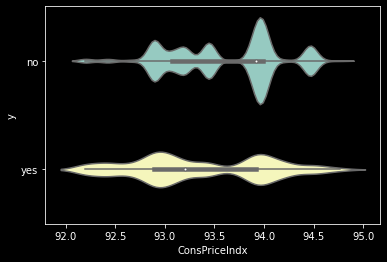

In [28]:
seaborn.violinplot(data=df.toPandas(), x='ConsPriceIndx', y='y')

<AxesSubplot:xlabel='ConsConfIndx', ylabel='y'>

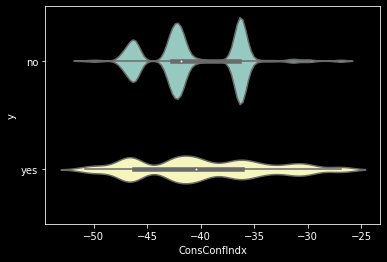

In [29]:
seaborn.violinplot(data=df.toPandas(), x='ConsConfIndx', y='y')

<AxesSubplot:xlabel='euribor3m', ylabel='y'>

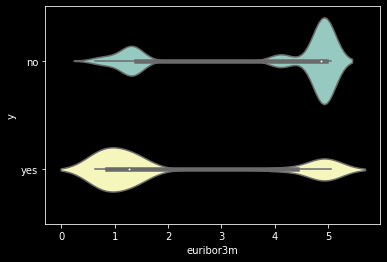

In [30]:
seaborn.violinplot(data=df.toPandas(), x='euribor3m', y='y')

<AxesSubplot:xlabel='NrEmployed', ylabel='y'>

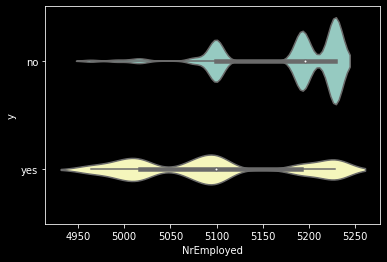

In [31]:
seaborn.violinplot(data=df.toPandas(), x='NrEmployed', y='y') 

In [32]:
df.groupBy('marital').pivot('y').count().show()

+--------+-----+----+
| marital|   no| yes|
+--------+-----+----+
| unknown|   68|  12|
|divorced| 4136| 476|
| married|22396|2532|
|  single| 9948|1620|
+--------+-----+----+



In [33]:
df.groupBy('job').pivot('y').count().show()

+-------------+----+----+
|          job|  no| yes|
+-------------+----+----+
|   management|2596| 328|
|      retired|1286| 434|
|      unknown| 293|  37|
|self-employed|1272| 149|
|      student| 600| 275|
|  blue-collar|8616| 638|
| entrepreneur|1332| 124|
|       admin.|9070|1352|
|   technician|6013| 730|
|     services|3646| 323|
|    housemaid| 954| 106|
|   unemployed| 870| 144|
+-------------+----+----+



In [34]:
df.groupBy('education').pivot('y').count().show()

+-------------------+-----+----+
|          education|   no| yes|
+-------------------+-----+----+
|        high.school| 8484|1031|
|            unknown| 1480| 251|
|           basic.6y| 2104| 188|
|professional.course| 4648| 595|
|  university.degree|10498|1670|
|         illiterate|   14|   4|
|           basic.4y| 3748| 428|
|           basic.9y| 5572| 473|
+-------------------+-----+----+



In [35]:
df.groupBy('default').pivot('y').count().show()

+-------+-----+----+
|default|   no| yes|
+-------+-----+----+
|unknown| 8154| 443|
|     no|28391|4197|
|    yes|    3|null|
+-------+-----+----+



In [36]:
df.groupBy('housing').pivot('y').count().show()

+-------+-----+----+
|housing|   no| yes|
+-------+-----+----+
|unknown|  883| 107|
|     no|16596|2026|
|    yes|19069|2507|
+-------+-----+----+



In [37]:
df.groupBy('loan').pivot('y').count().show()

+-------+-----+----+
|   loan|   no| yes|
+-------+-----+----+
|unknown|  883| 107|
|     no|30100|3850|
|    yes| 5565| 683|
+-------+-----+----+



In [38]:
df.groupBy('contact').pivot('y').count().show()

+---------+-----+----+
|  contact|   no| yes|
+---------+-----+----+
| cellular|22291|3853|
|telephone|14257| 787|
+---------+-----+----+



In [39]:
df.groupBy('month').pivot('y').count().show()

+-----+-----+---+
|month|   no|yes|
+-----+-----+---+
|  jun| 4759|559|
|  aug| 5523|655|
|  may|12883|886|
|  sep|  314|256|
|  mar|  270|276|
|  oct|  403|315|
|  jul| 6525|649|
|  nov| 3685|416|
|  apr| 2093|539|
|  dec|   93| 89|
+-----+-----+---+



In [40]:
df.groupBy('day_of_week').pivot('y').count().show()

+-----------+----+----+
|day_of_week|  no| yes|
+-----------+----+----+
|        fri|6981| 846|
|        thu|7578|1045|
|        tue|7137| 953|
|        wed|7185| 949|
|        mon|7667| 847|
+-----------+----+----+



In [41]:
df.groupBy('poutcome').pivot('y').count().show()

+-----------+-----+----+
|   poutcome|   no| yes|
+-----------+-----+----+
|    success|  479| 894|
|    failure| 3647| 605|
|nonexistent|32422|3141|
+-----------+-----+----+



In [42]:
#pyspark.pandas.df.plot.bar(x='y', y='age') 

In [43]:
#performing pearson coefficient
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,EmpVarRate,ConsPriceIndx,ConsConfIndx,euribor3m,NrEmployed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
EmpVarRate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
ConsPriceIndx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
ConsConfIndx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
NrEmployed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


#### EmpVarRate and NrEmployed highly correlated
#### euribor3m and NrEmployed highly correlated

### Age Binning 

In [44]:
def udf_multiple(age):
      if (age <= 25):
        return 'Under 25'
      elif (age >= 25 and age <= 35):
        return 'Between 25 and 35'
      elif (age > 35 and age < 50):
        return 'Between 36 and 49'
      elif (age >= 50):
        return 'Over 50'
      else: return 'N/A'

age_udf = udf(udf_multiple)
df=df.withColumn("Age_udf", age_udf('age')).drop('age')

In [45]:
df.groupby("Age_udf").count().show()

+-----------------+-----+
|          Age_udf|count|
+-----------------+-----+
|Between 25 and 35|14847|
|         Under 25| 1666|
|Between 36 and 49|16620|
|          Over 50| 8055|
+-----------------+-----+



In [46]:
df.toPandas()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,EmpVarRate,ConsPriceIndx,ConsConfIndx,euribor3m,NrEmployed,y,Age_udf
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50
2,services,married,high.school,no,yes,no,telephone,may,mon,226,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Between 36 and 49
4,services,married,high.school,no,no,yes,telephone,may,mon,307,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Over 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Over 50
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Between 36 and 49
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Over 50
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,442,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Between 36 and 49


### String Index Found this code
https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe

In [47]:
#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string') ]

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df= pipelineModel.transform(df)

In [48]:
df=df.drop('yIndex')
df.toPandas()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,...,maritalIndex,educationIndex,defaultIndex,housingIndex,loanIndex,contactIndex,monthIndex,day_of_weekIndex,poutcomeIndex,Age_udfIndex
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,...,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
2,services,married,high.school,no,yes,no,telephone,may,mon,226,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,...,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,services,married,high.school,no,no,yes,telephone,may,mon,307,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,...,0.0,3.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,...,0.0,3.0,0.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,442,...,0.0,3.0,0.0,1.0,0.0,0.0,4.0,4.0,0.0,0.0


In [49]:
df.printSchema()

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- EmpVarRate: double (nullable = true)
 |-- ConsPriceIndx: double (nullable = true)
 |-- ConsConfIndx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- NrEmployed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- Age_udf: string (nullable = true)
 |-- jobIndex: double (nullable = false)
 |-- maritalIndex: double (nullable = false)
 |-- educationIndex: double (nullable = false)
 |-- defaultIndex: double (

### One Hot Encoding

In [50]:
encoder = OneHotEncoder()\
         .setInputCols (["jobIndex","maritalIndex","educationIndex","defaultIndex","housingIndex",\
                        "loanIndex", "contactIndex","monthIndex","day_of_weekIndex","poutcomeIndex","Age_udfIndex" ])\
         .setOutputCols (["jobEncoded", "maritalEncoded","educationEncoded","defaultEncoded","housingEncoded",\
                         "loanEncoded","contactEncoded","monthEncoded","day_of_weekEncoded","poutcomeEncoded","Age_udfEncoded"])

encoder_model=encoder.fit(df)
encoder_df=encoder_model.transform(df)

encoder_df.toPandas().head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,...,maritalEncoded,educationEncoded,defaultEncoded,housingEncoded,loanEncoded,contactEncoded,monthEncoded,day_of_weekEncoded,poutcomeEncoded,Age_udfEncoded
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,...,"(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)"
1,services,married,high.school,unknown,no,no,telephone,may,mon,149,...,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)"
2,services,married,high.school,no,yes,no,telephone,may,mon,226,...,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)"
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,...,"(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(1.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)"
4,services,married,high.school,no,no,yes,telephone,may,mon,307,...,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0)","(0.0, 1.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)"


In [51]:
encoder_df=encoder_df.drop("jobIndex","maritalIndex","educationIndex","defaultIndex","housingIndex",\
                        "loanIndex", "contactIndex","monthIndex","day_of_weekIndex","poutcomeIndex","Age_udfIndex",\
                          "job","marital","default","education","housing","loan","contact","month","day_of_week",\
                           "poutcome","Age_udf")


In [52]:
encoder_df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- EmpVarRate: double (nullable = true)
 |-- ConsPriceIndx: double (nullable = true)
 |-- ConsConfIndx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- NrEmployed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- jobEncoded: vector (nullable = true)
 |-- maritalEncoded: vector (nullable = true)
 |-- educationEncoded: vector (nullable = true)
 |-- defaultEncoded: vector (nullable = true)
 |-- housingEncoded: vector (nullable = true)
 |-- loanEncoded: vector (nullable = true)
 |-- contactEncoded: vector (nullable = true)
 |-- monthEncoded: vector (nullable = true)
 |-- day_of_weekEncoded: vector (nullable = true)
 |-- poutcomeEncoded: vector (nullable = true)
 |-- Age_udfEncoded: vector (nullable = true)



### Vector Assembler

In [53]:
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

In [54]:
assembler = VectorAssembler()\
         .setInputCols (["duration","campaign","pdays","previous", "EmpVarRate","ConsPriceIndx",\
                         "ConsConfIndx","euribor3m", "NrEmployed","jobEncoded","maritalEncoded",\
                         "educationEncoded","defaultEncoded","housingEncoded", "loanEncoded",\
                        "contactEncoded", "monthEncoded", "day_of_weekEncoded","poutcomeEncoded","Age_udfEncoded"])\
         .setOutputCol ("vectorized_features")
        
# In case of missing you can skip the invalid ones
assembler_df=assembler.setHandleInvalid("skip").transform(encoder_df)
assembler_df.toPandas().head()

,duration,campaign,pdays,previous,EmpVarRate,ConsPriceIndx,...,contactEncoded,monthEncoded,day_of_weekEncoded,poutcomeEncoded,Age_udfEncoded,vectorized_features
0,261,1,999,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)","(261.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 0..."
1,149,1,999,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)","(149.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1..."
2,226,1,999,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(226.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1..."
3,151,1,999,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(151.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 1.0, 0.0, 0.0, 0..."
4,307,1,999,0,1.1,93.994,...,(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0)","(307.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0, 0.0, 0.0, 0.0, 1..."


### Label Indexer

In [55]:
label_indexer = StringIndexer()\
         .setInputCol ("y")\
         .setOutputCol ("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df=label_indexer_model.transform(assembler_df)

label_indexer_df.select("y","label").toPandas().head()

,y,label
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
4,no,0.0


### Standard Scaler

In [56]:
scaler = StandardScaler()\
         .setInputCol ("vectorized_features")\
         .setOutputCol ("features")
        
scaler_model=scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 40)
scaler_df.select("vectorized_features","features").toPandas().head(5)

,vectorized_features,features
0,"(261.0, 1.0, 999.0, 0.0, 1.1, 93.994...","(1.0066366713543708, 0.3610090653030..."
1,"(149.0, 1.0, 999.0, 0.0, 1.1, 93.994...","(0.5746699771333381, 0.3610090653030..."
2,"(226.0, 1.0, 999.0, 0.0, 1.1, 93.994...","(0.8716470794102981, 0.3610090653030..."
3,"(151.0, 1.0, 999.0, 0.0, 1.1, 93.994...","(0.5823836681015708, 0.3610090653030..."
4,"(307.0, 1.0, 999.0, 0.0, 1.1, 93.994...","(1.1840515636237234, 0.3610090653030..."


In [57]:
scaler_df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- EmpVarRate: double (nullable = true)
 |-- ConsPriceIndx: double (nullable = true)
 |-- ConsConfIndx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- NrEmployed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- jobEncoded: vector (nullable = true)
 |-- maritalEncoded: vector (nullable = true)
 |-- educationEncoded: vector (nullable = true)
 |-- defaultEncoded: vector (nullable = true)
 |-- housingEncoded: vector (nullable = true)
 |-- loanEncoded: vector (nullable = true)
 |-- contactEncoded: vector (nullable = true)
 |-- monthEncoded: vector (nullable = true)
 |-- day_of_weekEncoded: vector (nullable = true)
 |-- poutcomeEncoded: vector (nullable = true)
 |-- Age_udfEncoded: vector (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- label: double (nullable = f

### Train/Test Split

In [58]:
train, test = scaler_df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [59]:
train.groupby("y").count().show()
test.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|29154|
|yes| 3740|
+---+-----+

+---+-----+
|  y|count|
+---+-----+
| no| 7394|
|yes|  900|
+---+-----+



### Model Training

In [60]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 1.0830271959091928, 5.34479241...","[2.7164311262425525, -2.716431126242...",0.0,"[0.9379892729734995, 0.0620107270265..."
1,0.0,"(0.015427381936465452, 0.36100906530...","[3.7165228442010303, -3.716522844201...",0.0,"[0.976258963737435, 0.02374103626256..."
2,0.0,"(0.015427381936465452, 1.44403626121...","[4.538781455635892, -4.538781455635892]",0.0,"[0.989426571601645, 0.01057342839835..."
3,0.0,"(0.015427381936465452, 7.22018130606...","[4.218561912463805, -4.218561912463805]",0.0,"[0.9854937316854745, 0.0145062683145..."
4,0.0,"(0.019284227420581817, 0.36100906530...","[4.399290758359037, -4.399290758359037]",0.0,"[0.9878630644122729, 0.0121369355877..."


# Confusion Matrix


In [61]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 379  521]
 [ 185 7209]]


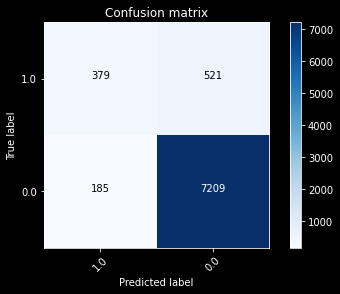

In [62]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Accuracy

In [63]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9148782252230528


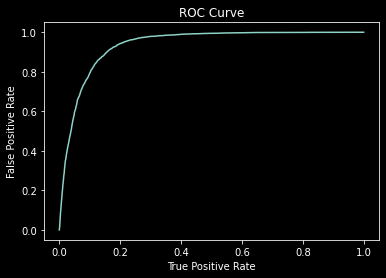

Training set areaUnderROC: 0.93532126923998


In [64]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9369272383013261


In [72]:
# Decision Tree

from pyspark.ml.classification import DecisionTreeClassifier
#from pyspark.mllib.util import MLUtils

# Train a DecisionTree model.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', impurity='gini', maxDepth=5, maxBins=32, seed=2018)
model_dt = dt.fit(train)
pred = model_dt.transform(test)
pred.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)


,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 1.0830271959091928, 5.34479241...","[1497.0, 258.0]",0.0,"[0.852991452991453, 0.147008547008547]"
1,0.0,"(0.015427381936465452, 0.36100906530...","[16.0, 31.0]",1.0,"[0.3404255319148936, 0.6595744680851..."
2,0.0,"(0.015427381936465452, 1.44403626121...","[22478.0, 171.0]",0.0,"[0.9924499977923971, 0.0075500022076..."
3,0.0,"(0.015427381936465452, 7.22018130606...","[22478.0, 171.0]",0.0,"[0.9924499977923971, 0.0075500022076..."
4,0.0,"(0.019284227420581817, 0.36100906530...","[22478.0, 171.0]",0.0,"[0.9924499977923971, 0.0075500022076..."


Confusion matrix, without normalization
[[ 531  369]
 [ 313 7081]]


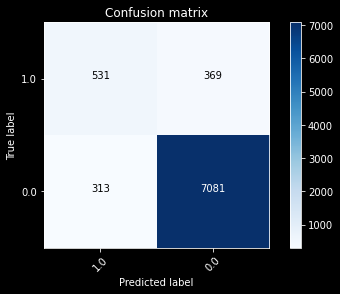

In [73]:
# Evaluation of DT
y_true = pred.select("label")
y_true = y_true.toPandas()

y_pred = pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [74]:
# accuracy of DT
accuracy = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9177718832891246


In [75]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC for Decision Tree', evaluator.evaluate(pred))

Test Area Under ROC for Decision Tree 0.8022908213867099


In [76]:
# Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=2018)
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)

predictions_rf.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 1.0830271959091928, 5.34479241...","[18.20868998811974, 1.7913100118802583]",0.0,"[0.910434499405987, 0.08956550059401..."
1,0.0,"(0.015427381936465452, 0.36100906530...","[15.165698679045114, 4.834301320954884]",0.0,"[0.7582849339522557, 0.2417150660477..."
2,0.0,"(0.015427381936465452, 1.44403626121...","[19.275356838746752, 0.7246431612532...",0.0,"[0.9637678419373377, 0.0362321580626..."
3,0.0,"(0.015427381936465452, 7.22018130606...","[19.255767757787616, 0.7442322422123...",0.0,"[0.9627883878893808, 0.0372116121106..."
4,0.0,"(0.019284227420581817, 0.36100906530...","[19.2822774772653, 0.7177225227346984]",0.0,"[0.964113873863265, 0.03588612613673..."


Confusion matrix, without normalization
[[ 178  722]
 [  51 7343]]


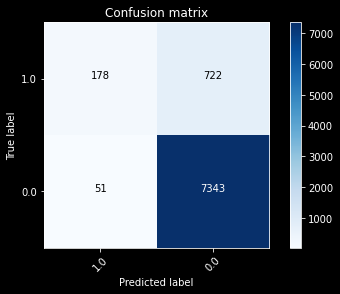

In [77]:
# Evaluation of RF
y_true = predictions_rf.select("label")
y_true = y_true.toPandas()

y_pred = predictions_rf.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [78]:
# accuracy of RF
accuracy = predictions_rf.filter(predictions_rf.label == predictions_rf.prediction).count() / float(predictions_rf.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9068000964552688


In [79]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC for Random Forest', evaluator.evaluate(predictions_rf))

Test Area Under ROC for Random Forest 0.9257834430318886


In [80]:
# Gradient boosting tree
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features', seed=2018)
gbModel = gb.fit(train)
predictions_gb = gbModel.transform(test)

predictions_gb.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 1.0830271959091928, 5.34479241...","[1.3325846364134852, -1.332584636413...",0.0,"[0.9349398076498788, 0.0650601923501..."
1,0.0,"(0.015427381936465452, 0.36100906530...","[0.6667920428735472, -0.666792042873...",0.0,"[0.7914328666183628, 0.2085671333816..."
2,0.0,"(0.015427381936465452, 1.44403626121...","[1.5298910074818624, -1.529891007481...",0.0,"[0.9552029702402346, 0.0447970297597..."
3,0.0,"(0.015427381936465452, 7.22018130606...","[1.5298910074818624, -1.529891007481...",0.0,"[0.9552029702402346, 0.0447970297597..."
4,0.0,"(0.019284227420581817, 0.36100906530...","[1.5298910074818624, -1.529891007481...",0.0,"[0.9552029702402346, 0.0447970297597..."


Confusion matrix, without normalization
[[ 495  405]
 [ 269 7125]]


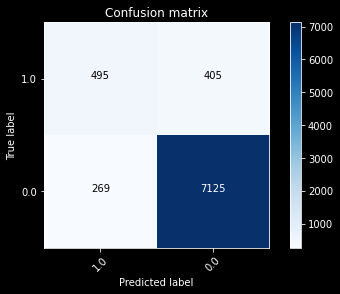

In [81]:
# Evaluation of GB
y_true = predictions_gb.select("label")
y_true = y_true.toPandas()

y_pred = predictions_gb.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [82]:
accuracy = predictions_gb.filter(predictions_gb.label == predictions_gb.prediction).count() / float(predictions_gb.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9187364359778153


In [83]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC for GB', evaluator.evaluate(predictions_gb))

Test Area Under ROC for GB 0.9462636371833021


Therefore, gradient boosting gives us the best result in terms of Test ROC and other metrics

### Kmeans Clustering

In [84]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(scaler_df)
    
    output=KMeans_fit.transform(scaler_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.2046549547050349
Silhouette Score: 0.0905276570672348
Silhouette Score: 0.10367231175094002
Silhouette Score: 0.10381577576908733
Silhouette Score: 0.12933368210271304
Silhouette Score: 0.09663649746506149
Silhouette Score: 0.10894080238143342
Silhouette Score: 0.12349270265990947


Text(0, 0.5, 'cost')

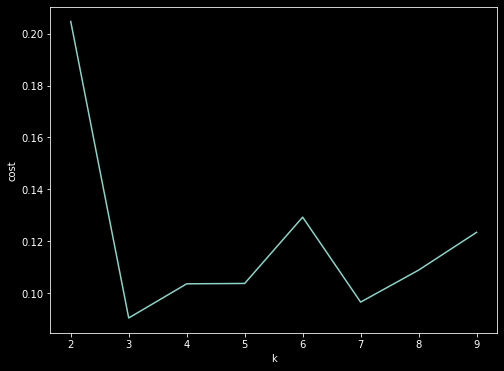

In [85]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [86]:
### Using 2 clusters

kmeans =KMeans(featuresCol='features', k=2)
model = kmeans.fit(scaler_df)
# Make predictions
predictions_Kmeans2 = model.transform(scaler_df)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions_Kmeans2)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
print(center)
predictions_Kmeans2.toPandas().head(5)

Silhouette with squared euclidean distance = 0.2046549547050349
Cluster Centers: 
[ 9.77480545e-01  1.01966713e+00  5.34479242e+00  0.00000000e+00
  7.31344677e-01  1.62152093e+02 -8.51155871e+00  2.78833636e+00
  7.21626752e+01  5.68379448e-01  5.65384596e-01  4.75725604e-01
  3.34401888e-01  2.76482756e-01  1.45577031e-01  2.02899257e-01
  1.92690307e-01  1.88828845e-01  1.50580632e-01  4.88806530e-02
  1.30127419e+00  5.47848068e-01  3.68105913e-01  6.26829930e-01
  5.32672047e-01  4.23205365e-01  3.95120138e-01  3.54694774e-01
  2.55848030e-01  2.08918964e-01  1.81291210e+00  6.47284434e-01
  1.00647472e+00  9.50043400e-01  2.16544258e+00  4.21927844e-01
  1.02407706e+00  6.10467523e-01  6.53885724e-01  5.37650843e-01
  4.83892519e-01  3.57437460e-01  0.00000000e+00  1.84244493e-02
  0.00000000e+00  0.00000000e+00  5.07970403e-01  4.90937002e-01
  5.17083421e-01  5.09925845e-01  2.91209121e+00  0.00000000e+00
  8.85076869e-01  7.16773693e-01  4.89905512e-01]


,duration,campaign,pdays,previous,EmpVarRate,ConsPriceIndx,...,poutcomeEncoded,Age_udfEncoded,vectorized_features,label,features,prediction
0,261,1,999,0,1.1,93.994,...,"(1.0, 0.0)","(0.0, 0.0, 1.0)","(261.0, 1.0, 999.0, 0.0, 1.1, 93.994...",0.0,"(1.0066366713543708, 0.3610090653030...",1
1,149,1,999,0,1.1,93.994,...,"(1.0, 0.0)","(0.0, 0.0, 1.0)","(149.0, 1.0, 999.0, 0.0, 1.1, 93.994...",0.0,"(0.5746699771333381, 0.3610090653030...",1
2,226,1,999,0,1.1,93.994,...,"(1.0, 0.0)","(1.0, 0.0, 0.0)","(226.0, 1.0, 999.0, 0.0, 1.1, 93.994...",0.0,"(0.8716470794102981, 0.3610090653030...",1
3,151,1,999,0,1.1,93.994,...,"(1.0, 0.0)","(1.0, 0.0, 0.0)","(151.0, 1.0, 999.0, 0.0, 1.1, 93.994...",0.0,"(0.5823836681015708, 0.3610090653030...",1
4,307,1,999,0,1.1,93.994,...,"(1.0, 0.0)","(0.0, 0.0, 1.0)","(307.0, 1.0, 999.0, 0.0, 1.1, 93.994...",0.0,"(1.1840515636237234, 0.3610090653030...",1
